<h1>Operability analysis of a multistage membrane separation process for direct air capture (m-DAC)</h1>

In order to address the impacts of fossil fuel emissions to climate change, CO<sub>2</sub> capture have been expanded from usual point-source capture to CO<sub>2</sub> removal from the atmosphere. The process described in the figure simulates the use of gas separation membranes for the CO<sub>2</sub>  removal.

![m-DAC Process flow diagram](m-DAC_ProcessPFD.png)

This capture aims to remove CO<sub>2</sub> from the air (CO<sub>2</sub> ~ 420 ppm) and concentrate it to around 5%. The process was simulated in AVEVA Process Simulation, a commercial process simualtion platform that contains a membrane model available.

<h2>Step-by-step set up of Opyrability with AVEVA Process Simulation</h2>

<h2>Step 1: Necessary imports for connection with APS and for Operability computations:</h2>

<h4> APS connection import</h4>

In [32]:
import simcentralconnect #AVEVA PROCESS SIMULATION REQUIRED IMPORT TO ENABLE CONNECTION

<color><red><i>This import is essential to enable communication with APS. Once you have installed and configured your APS, you should be able to find the Scripting Interface files. In it, a step-by-step README file guides the user through enabling the connection.</i></color></red>

In [33]:
import numpy as np
from opyrability import AIS2AOS_map, multimodel_rep, OI_eval #Operability algorigthms import from Opyrability library
from scipy.io import savemat

# Instantiating the required interfaces for the scripting interface

sc = simcentralconnect.connect().Result
sm = sc.GetService("ISimulationManager")
vm = sc.GetService("IVariableManager")
snap = sc.GetService("ISnapshotManager")

# Example of how to set options.  API logging is ON by default.  Disabled by changing to 'false'
sc.SetOptions(repr({'Timeout': 100000, 'EnableApiLogging': 'false'}))

SimCentral.Client.Auto loaded from: PATH


<h2>Step 2: Calling the simulation file you want to work with:</h2>

In [34]:
simFile = "APS_mDAC"
simName = "APS_mDAC" #WARNING: Sometimes APS might rename your simulation as its opened so always make sure the name of the simulation you are working with aligns with the current opened simulation
nameSnap = "steady" #Note: This is only required in case the user wants to set the simulation to a specific snapshot

<h2>Step 3: Function for double checking if simulation exist:</h2>

In [35]:
def open_simulation(simName):
    opened = False
    try:
        opened = sm.OpenSimulation(simName).Result
    except System.AggregateException as ex:
        if not isinstance(ex.InnerException, System.InvalidOperationException) \
                or "simulation doesn't exists" not in ex.InnerException.Message:
            raise
    return opened



open_simulation(simName)

True

<h2>Step 4: Process model function to communicate with APS and Opyrability:</h2>

In [ ]:
def M(u):

    y = np.zeros(2) #Prealocating outputs
     
    # Membrane properties case
    
    #First membrane module study

    #Parameters required for SetVariable method vm.SetVariableValue(<string> simulation name, <object> variable, <object> value, <object> unit, <object> apiOptions)(more on methods and interfaces is available in the AVEVA Scripting Interface documentation)
    vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result 
    vm.SetVariableValue(simName, "MDAC1.Selectivity", u[1], "", ).Result

    # --------- Checking solution status ----------------------------- 

    simstat = sm.GetSimulationStatus(simName).Result
    print(str(simstat[2]))   

    if (simstat[2]):
        flag_conv = True
    else:
        flag_conv= False

    if flag_conv is True:
        
        # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

        feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
        prod_F2 = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
        purity2 =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result       

        # ---------------- AOS VARIABLES --------------------------------------------------
                
        # -------------------- Purity vs. Recovery case study ----------------------
        y[0] = purity2*100
        y[1] = 100*((prod_F2*purity2) / (feed_flow*0.000420))
        
    else:
            # --------- Restarting solver to try again -----------------------------
        
            snap.RevertSnapshot(simName,nameSnap)

            # --------- Checking solution status again-----------------------------   
                
            simstat = sm.GetSimulationStatus(simName).Result

            print(u[0], u[1],"failed")
            if (simstat[2]):
                flag_conv = True
            else:
                flag_conv= False
            
            if flag_conv is True:
                            
                # ------------------- MEMBRANE PROPERTIES CASE -------------------------------
                #First membrane module study
                vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result
                vm.SetVariableValue(simName, "MDAC1.Selectivity", u[1], "", ).Result
            
                       
                # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

                feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result               
                prod_F2 = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
                purity2 =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result                
   
                
                # ---------------- AOS VARIABLES --------------------------------------------------
                
                # -------------------- Purity vs. Recovery case study ----------------------
                y[0] = purity2*100
                y[1] = 100*((prod_F2*purity2) / (feed_flow*0.000420))              
                
            else:
                pass
            
            
    return y #Returning outputs for the Operability study

<h2>Step 5: Defining Operability study </h2>

True
True
True
True
True
True
False
3.35e-08 506.0 failed
True
True
True
True
False
3.35e-08 1004.0 failed
True
True
True
True
False
3.35e-08 1502.0 failed
True
True
True
True
False
3.35e-08 2000.0 failed
True
True
True
True


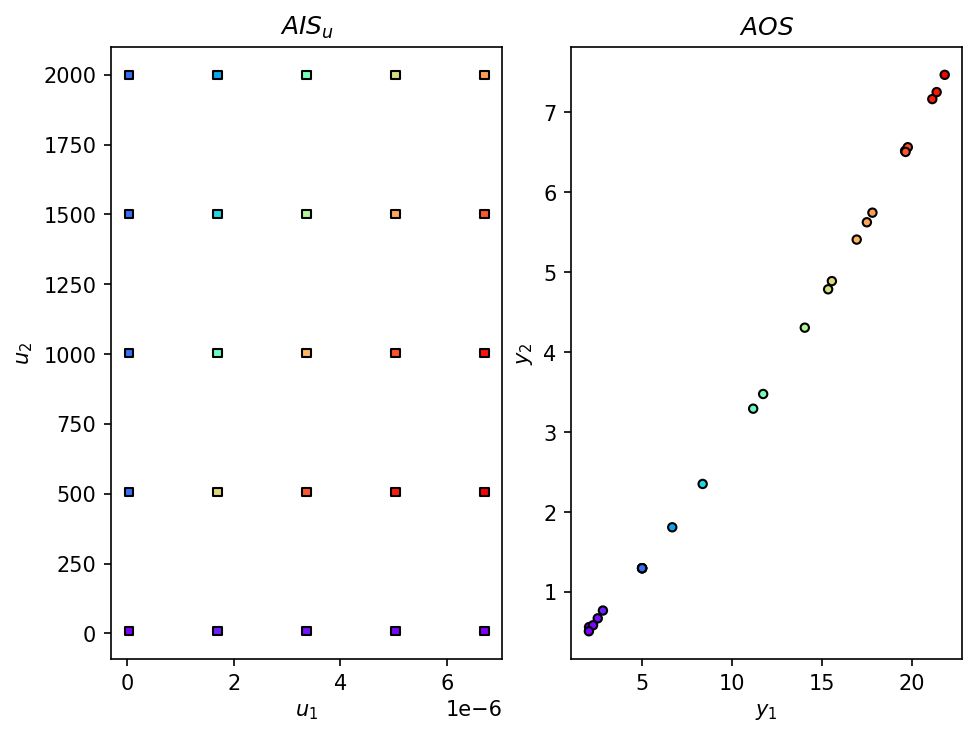

In [37]:
#---------------------- OPERABILIY STUDY --------------------------------------------------

AIS_bounds =  np.array([[3.35e-8, 6.7e-06],[8, 2000]]) #AIS bounds definition for the 2 inputs x 2 outputs case study


AIS_resolution =  [5,5] #AIS discretization definition for the 2 inputs x 2 outputs case study

AIS, AOS = AIS2AOS_map(M, AIS_bounds, AIS_resolution) #Forwad mapping call for the 2 inputs x 2 outputs case study